--- Performance Metrics ---
Hypervolume (SA_NSGA-II): 0.000335
Hypervolume (2_stage_SA_NSGA-II): 0.000626
Hypervolume (2_stage_SA-NSGA-II_LS): 0.000627
Hypervolume (INIT_SA_NSGA-II): 0.000460
Hypervolume (SA_NSGA-II_LS): 0.000461
Hypervolume (INIT_SA_NSGA-II_LS): 0.000099
Hypervolume (MOBO): 0.000264
Hypervolume (2_stage_MOBO): 0.000634
-------------------------
GD (SA_NSGA-II):  0.280140
IGD(SA_NSGA-II): 0.170028
GD (2_stage_SA_NSGA-II):  0.000000
IGD(2_stage_SA_NSGA-II): 0.018489
GD (2_stage_SA-NSGA-II_LS):  0.000000
IGD(2_stage_SA-NSGA-II_LS): 0.017924
GD (INIT_SA_NSGA-II):  0.026826
IGD(INIT_SA_NSGA-II): 0.256464
GD (SA_NSGA-II_LS):  0.552083
IGD(SA_NSGA-II_LS): 0.173632
GD (INIT_SA_NSGA-II_LS):  0.003452
IGD(INIT_SA_NSGA-II_LS): 0.515835
GD (MOBO):  0.528876
IGD(MOBO): 0.257835
GD (2_stage_MOBO):  0.000000
IGD(2_stage_MOBO): 0.010094
-------------------------
Spread (SA_NSGA-II): 1.071256
Spread (2_stage_SA_NSGA-II): 1.000000
Spread (2_stage_SA-NSGA-II_LS): 1.000000
Spread (INIT_S

/tmp/ipykernel_3647987/4063485890.py:216: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


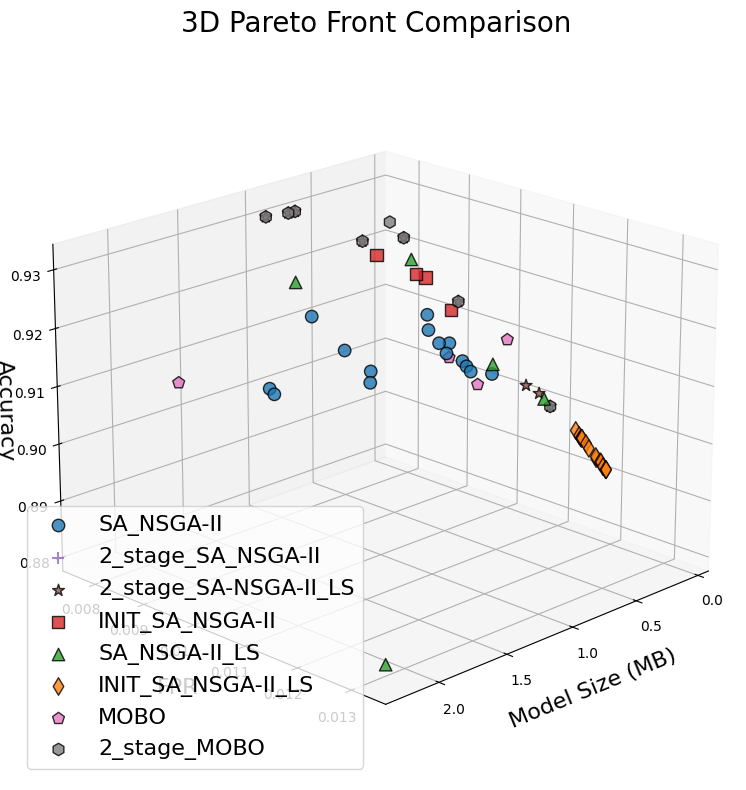

/tmp/ipykernel_3647987/4063485890.py:244: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(


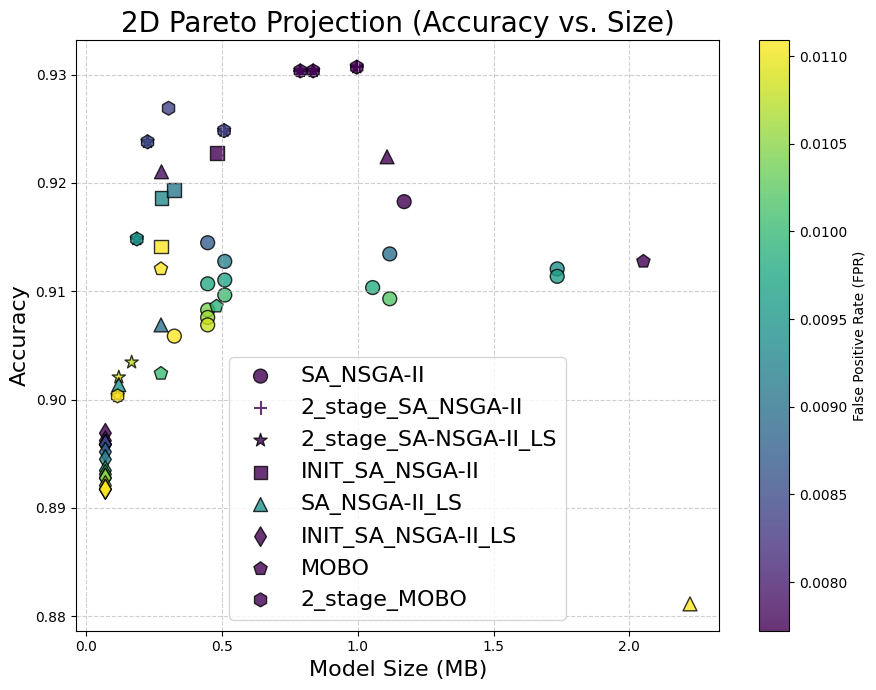

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pygmo as pg

# ----------------------------------------
# 1. Configure your Pareto-front files
#    Simply add your new method and its corresponding Excel file path here.
# ----------------------------------------

paths = {
    # --- Existing methods ---
    "SA_NSGA-II":           "SA_NSGA-II.xlsx",
				"2_stage_SA_NSGA-II":   "2_stage_SA_NSGA-II.xlsx",
    "2_stage_SA-NSGA-II_LS":"2_stage_SA-NSGA-II_LS.xlsx",
    "INIT_SA_NSGA-II":      "SA-NSGA_init.xlsx",
				"SA_NSGA-II_LS":        "SA_NSGA_local.xlsx",
    "INIT_SA_NSGA-II_LS":   "init_sa_nsga_local.xlsx",
    "MOBO":                 "mobo.xlsx",
    "2_stage_MOBO":         "2_stage.xlsx"
}


# ----------------------------------------
# 2. Load each front into a dictionary of arrays
#    This part of the code does not need changes.
# ----------------------------------------
fronts = {}
for name, path in paths.items():
    try:
        df = pd.read_excel(path)
        # Ensure the columns exist before trying to access them
        required_cols = ["Accuracy", "Size_MB", "FPR"]
        if all(col in df.columns for col in required_cols):
            fronts[name] = df[required_cols].to_numpy()
        else:
            print(f"Warning: File '{path}' is missing one of the required columns: {required_cols}. Skipping.")
    except FileNotFoundError:
        print(f"Warning: File '{path}' not found. Skipping method '{name}'.")
    except Exception as e:
        print(f"Error loading {path}: {e}")


# ----------------------------------------
# 3. Convert to minimization-space for hypervolume
#    We want to minimize (-Accuracy, Size, FPR).
#    This part of the code does not need changes.
# ----------------------------------------
min_fronts = {}
for name, arr in fronts.items():
    min_fronts[name] = np.column_stack([
        -arr[:,0],      # -Accuracy
         arr[:,1],      # Model_Size
         arr[:,2]       # FPR
    ])

# ----------------------------------------
# 4. Build a common reference point r = (r1, r2, r3) for hypervolume
#    This should be a "worst-case" point dominated by all solutions.
#    This part of the code does not need changes.
# ----------------------------------------
# Check if any fronts were loaded successfully
if not min_fronts:
    print("No valid data loaded. Exiting.")
    exit()

all_objs = np.vstack(list(min_fronts.values()))
eps = 1e-3 # A small epsilon to ensure the reference point is strictly worse
r = [
    all_objs[:,0].max() + eps,
    all_objs[:,1].max() + eps,
    all_objs[:,2].max() + eps
]

# ----------------------------------------
# 5. Compute Hypervolumes
#    This part of the code does not need changes.
# ----------------------------------------
print("--- Performance Metrics ---")
hvs = {}
for name, mf in min_fronts.items():
    # Pygmo expects a list of lists, not a numpy array
    hv_calculator = pg.hypervolume(mf.tolist())
    hv = hv_calculator.compute(r)
    hvs[name] = hv
    print(f"Hypervolume ({name}): {hv:.6f}")
print("-" * 25)

# ----------------------------------------
# 6. Assemble the "true" Pareto front from all provided solutions
#    This is done by taking the union of all points and filtering out dominated ones.
#    This part of the code does not need changes.
# ----------------------------------------
def dominates_min(a, b):
    """Check if solution a dominates solution b (for minimization problems)."""
    # a is better if all its objectives are <= b's, and at least one is <
    return np.all(a <= b) and np.any(a < b)

combined = all_objs
mask = np.ones(combined.shape[0], dtype=bool)
for i in range(len(combined)):
    for j in range(len(combined)):
        if i != j and dominates_min(combined[j], combined[i]):
            mask[i] = False
            break # No need to check other points, we know i is dominated
true_front = combined[mask]

# ----------------------------------------
# 7. Generational Distance (GD) & Inverted Generational Distance (IGD)
#    GD: How far is the found front from the true front? (Convergence)
#    IGD: How well does the found front cover the true front? (Convergence + Diversity)
#    This part of the code does not need changes.
# ----------------------------------------
def generational_distance(obtained_front, true_front):
    """Calculates the Generational Distance."""
    distances = cdist(obtained_front, true_front)
    min_distances = np.min(distances, axis=1)
    return np.sqrt(np.mean(min_distances**2))

def inverted_gd(obtained_front, true_front):
    """Calculates the Inverted Generational Distance."""
    distances = cdist(true_front, obtained_front)
    min_distances = np.min(distances, axis=1)
    return np.sqrt(np.mean(min_distances**2))

gds, igds = {}, {}
for name, mf in min_fronts.items():
    gds[name]  = generational_distance(mf, true_front)
    igds[name] = inverted_gd(mf, true_front)
    print(f"GD ({name}):  {gds[name]:.6f}")
    print(f"IGD({name}): {igds[name]:.6f}")
print("-" * 25)

# ----------------------------------------
# 8. Spread (Diversity) metric
#    How evenly are the points distributed along the front?
#    This part of the code does not need changes.
# ----------------------------------------
def spread_metric(front, true_front):
    """Calculates the Spread (diversity) metric."""
    if len(front) < 2: return np.nan # Cannot compute for single points
    distances_to_true = np.min(cdist(front, true_front), axis=1)
    d_mean = np.mean(distances_to_true)
    
    # Distances to extreme points of the true front
    df = np.min(cdist(front, np.min(true_front, axis=0).reshape(1, -1)))
    dl = np.min(cdist(front, np.max(true_front, axis=0).reshape(1, -1)))

    numerator = df + dl + np.sum(np.abs(distances_to_true - d_mean))
    denominator = df + dl + (len(front) - 1) * d_mean
    return numerator / denominator if denominator != 0 else np.nan

spreads = {}
for name, mf in min_fronts.items():
    spreads[name] = spread_metric(mf, true_front)
    print(f"Spread ({name}): {spreads[name]:.6f}")
print("-" * 25)

# ----------------------------------------
# 9. Coverage (C-metric) between every pair of fronts
#    What fraction of front B is dominated by front A?
#    This part of the code does not need changes.
# ----------------------------------------
def coverage_metric(A, B):
    """Calculates C(A, B): the fraction of B dominated by A."""
    count = 0
    for b_point in B:
        if any(dominates_min(a_point, b_point) for a_point in A):
            count += 1
    return count / len(B) if len(B) > 0 else 0

print("Coverage (C-Metric):")
names = list(min_fronts.keys())
for name_a in names:
    for name_b in names:
        if name_a != name_b:
            c = coverage_metric(min_fronts[name_a], min_fronts[name_b])
            print(f"  C({name_a} covers {name_b}): {c:.3f}")
print("-" * 25)


# ----------------------------------------
# 10. Configure plotting styles
#     Add a new marker and color for your new method here.
# ----------------------------------------
markers = {
    "SA_NSGA-II":           "o",
    "SA_NSGA-II_LS":        "^",
    "INIT_SA_NSGA-II":      "s",
    "INIT_SA_NSGA-II_LS":   "d",
    "2_stage_SA_NSGA-II":   "+",
    "2_stage_SA-NSGA-II_LS":"*",
    "MOBO":                 "p",
    "2_stage_MOBO":         "h"
}
colors = {
    "SA_NSGA-II":           "tab:blue",
    "SA_NSGA-II_LS":        "tab:green",
    "INIT_SA_NSGA-II":      "tab:red",
    "INIT_SA_NSGA-II_LS":   "tab:orange",
    "2_stage_SA_NSGA-II":   "tab:purple",
    "2_stage_SA-NSGA-II_LS":"tab:brown",
    "MOBO":                 "tab:pink",
    "2_stage_MOBO":         "tab:gray"
}

# ----------------------------------------
# 11. 3D Scatter Plot
#     This part of the code does not need changes.
# ----------------------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for name, arr in fronts.items():
    ax.scatter(
        arr[:,1],        # Model Size (MB) -> x-axis
        arr[:,2],        # FPR             -> y-axis
        arr[:,0],        # Accuracy        -> z-axis
        label=name,
        marker=markers.get(name, 'x'), # Use 'x' as a default marker
        color=colors.get(name, 'k'),   # Use black as a default color
        s=80,
        edgecolor='k',
        alpha=0.8
    )

ax.set_xlabel("Model Size (MB)", fontsize=16, labelpad=10)
ax.set_ylabel("FPR", fontsize=16, labelpad=10)
ax.set_zlabel("Accuracy", fontsize=16, labelpad=0.5)
ax.set_title("3D Pareto Front Comparison", fontsize=20, pad=20)
ax.legend(fontsize=16)
ax.view_init(elev=20, azim=45) # Adjust viewing angle
plt.tight_layout()
plt.savefig("3-d")
plt.show()

# ----------------------------------------
# 12. 2D Projection (Accuracy vs. Model Size), colored by FPR
#     This part of the code does not need changes.
# ----------------------------------------
plt.figure(figsize=(9, 7))
for name, arr in fronts.items():
    sc = plt.scatter(
        arr[:,1], # x-axis: Model Size
        arr[:,0], # y-axis: Accuracy
        c=arr[:,2], # color: FPR
        cmap='viridis',
        label=name,
        marker=markers.get(name, 'x'),
        edgecolor='k',
        s=100,
        alpha=0.8
    )
plt.colorbar(sc, label="False Positive Rate (FPR)")
plt.xlabel("Model Size (MB)", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("2D Pareto Projection (Accuracy vs. Size)", fontsize=20)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("2-d")
plt.show()